# Connecting

In [1]:
import os

# setting working dir
os.chdir("../src")

In [2]:
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()

In [3]:
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

# Data Sourcing

In [4]:
from data_pipeline.data_sourcing import get_data

get_data?

Signature: get_data(workspace, es)
Docstring:
Get all the intents in the elasticsearch
workspace's index.

Parameters
----------
workspace: the workspace object
es: the elasticsearch conection instance

Returns
-------
list: a list of namedtuple Intents
    
Examples
--------

Raises
------

Notes
-----
File:      /usr/omni_nlu_api/src/data_pipeline/data_sourcing.py
Type:      function


In [5]:
data = get_data(workspace=workspace, es=es)
print(len(data))
print(data[0])

206
Intent(intent_name='Inativar_Posição', examples_text=['Como realizo a inativação de uma posição de minha estrutura?', 'Como realizo a reativação de uma posição em minha estrutura?', 'Em quanto tempo a inativação de uma posição é efetivada?', 'Gostaria de fazer a inativação de uma posição, como faço?', 'Realizei a inativação de uma posição e ela continua visível?'])


# Data Preprocessing

### Create artificial Examples

In [6]:
from data_pipeline.data_preprocessing import fill_missing_examples

fill_missing_examples?

Signature: fill_missing_examples(data, random_seed=42)
Docstring:
We expect at least 8 examples for each intent,
5 to train and 3 to test the ML models.

This function identify intents with less then 8 examples
and fill it up with artificial examples created from the 
exesting ones.

Parameters
----------
data: list of namedtuple representing Intents

Returns
-------
list: list of namedtuple representing Intents
    
Examples
--------
input = [
    Intent(
        intent_name='Inativar_Posição', 
        examples_text=['Como realizo a inativação de uma posição de minha estrutura?', 
                       'Como realizo a reativação de uma posição em minha estrutura?', 
                       'Em quanto tempo a inativação de uma posição é efetivada?', 
                       'Gostaria de fazer a inativação de uma posição, como faço?', 
                       'Realizei a inativação de uma posição e ela continua visível?']
        )
]

output = [
    Intent(
        intent_name='Inativar_

In [7]:
data = fill_missing_examples(data)

### Cleansing

In [8]:
from data_pipeline.data_preprocessing import clean_examples

clean_examples?

Signature: clean_examples(data)
Docstring:
Clean examples.

Parameters
----------
data: list of namedtuple representing Intents

Returns
-------
list: a list of namedtuple Examples.
    
Examples
--------

Please, see the TheDataFlow.ipynb notebook 
in the jupyter_notebook directory. Look for
Data Preprocessing topic and Cleansing sub-topic.

Raises
------

Notes
-----
File:      /usr/omni_nlu_api/src/data_pipeline/data_preprocessing.py
Type:      function


In [9]:
data = clean_examples(data)

In [10]:
data[0]

Intent(intent_name='Inativar_Posição', examples_text=['realiz inativ pos estrut', 'realiz reativ pos estrut', 'quant temp inativ pos efetiv', 'gost faz inativ pos fac', 'realiz inativ pos continu vis', 'realiz inativ um pos estrutur', 'realiz inativ um pos continu vis', 'quantum temp inativ um pos efetiv'])

# Data Splitting

In [11]:
from data_pipeline.data_splitting import data_splitting

data_splitting?

Signature: data_splitting(data, test_ratio=0.3, random_seed=42)
Docstring:
The split between train, valid and test sets occurs at the 
intent level. We want to assure that all intents 
are represented in boths sets.

Parameters
----------
data: list of namedtuple representing Intents

test_ratio: a float, between 0.0 and 1.0, that tells the
percentage of examples to chose from a intent if it has eight 
or more examples.

random_seed: the random seed.

Returns
-------
list: a list of namedtuple Examples.
    
Examples
--------

Please, see the TheDataFlow.ipynb notebook 
in the jupyter_notebook directory. Look for
Data Splitting topic.

Raises
------

Notes
-----
File:      /usr/omni_nlu_api/src/data_pipeline/data_splitting.py
Type:      function


In [12]:
train, test = data_splitting(data)

In [13]:
train.tail()

,intent_name,example_text
1091,Vizinho_Invadindo_Terreno,est problem vi unidad poss fal
1092,Vizinho_Invadindo_Terreno,vi unidad invad part imovel yar faz
1093,Vizinho_Invadindo_Terreno,terren est invad pel vizinh unidad faz
1094,Vizinho_Invadindo_Terreno,unidad est invad pod ajud
1095,Vizinho_Invadindo_Terreno,vizinh unidad est invad um part imovel yar faz


In [14]:
test.tail()

,intent_name,example_text
552,Visao_Geral_Previdencia_Privada,pod fal sobr previd priv
553,Visao_Geral_Previdencia_Privada,com funcion plan previd priv
554,Vizinho_Invadindo_Terreno,unidad send invad pod ajud
555,Vizinho_Invadindo_Terreno,terren send invad vi unidad faz
556,Vizinho_Invadindo_Terreno,est problem vi unidad pod fal


# Scikit Learn Pipe Line

In [15]:
# from sklearn.compose import make_column_transformer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [22]:
# transformer = LabelBinarizer()
transformer = LabelEncoder()
y_train = np.ravel(transformer.fit_transform(train.intent_name))
y_train

array([111, 111, 111, ..., 205, 205, 205])

In [67]:
transformer.inverse_transform([111, 100, 205, 0, 1])

array(['Inativar_Posição', 'Fazer_Contrato', 'Vizinho_Invadindo_Terreno',
       'Abono', 'Abrir_Chamado_Salario'], dtype=object)

In [53]:
hyper_parameters = {
          "C": 5,
          "fit_intercept": False,
          "random_state": 1,
          "max_iter": 1000
        }

logreg = LogisticRegression(
                    multi_class="multinomial",
                    n_jobs=-1,
                    **hyper_parameters
        )
        

model = Pipeline(
            steps= [
                ('text_features', TfidfVectorizer()),
                ('model', logreg)
            ]
        )

In [42]:
X_train = text_features.fit_transform(train.example_text)

In [54]:
cross_val_score(model, train.example_text, y_train, cv=5, scoring='accuracy').mean()

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.6688293897882939

In [55]:
model.fit(train.example_text, y_train)

Pipeline(steps=[('text_features', TfidfVectorizer()),
                ('model',
                 LogisticRegression(C=5, fit_intercept=False, max_iter=1000,
                                    multi_class='multinomial', n_jobs=-1,
                                    random_state=1))])

In [56]:
model.classes_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [26]:
X_test = text_features.fit_transform(train.example_text)

In [61]:
[train.example_text[0]]

['quant temp inativ pos efetiv']

In [60]:
model.predict_proba([train.example_text[0]])

array([[0.00161367, 0.00162917, 0.00153952, 0.00161252, 0.00160862,
        0.00162839, 0.00161768, 0.00776304, 0.00161973, 0.00159184,
        0.00161182, 0.00155349, 0.00161711, 0.00163906, 0.00157892,
        0.0016162 , 0.00162226, 0.00163381, 0.00162664, 0.00155312,
        0.00152386, 0.00160225, 0.00161829, 0.00160845, 0.00161433,
        0.00160944, 0.00323867, 0.00160048, 0.00162622, 0.00161679,
        0.00845913, 0.00544037, 0.00164158, 0.00163864, 0.00162907,
        0.00158999, 0.00159081, 0.00160694, 0.00155991, 0.00160983,
        0.00164227, 0.00163695, 0.00161367, 0.00160783, 0.00160283,
        0.00163553, 0.00163   , 0.00163305, 0.00162953, 0.00162846,
        0.00148005, 0.00162406, 0.00161066, 0.00159372, 0.00163411,
        0.00159805, 0.00162368, 0.00163461, 0.00162646, 0.00163889,
        0.00157984, 0.00157542, 0.00162571, 0.00162885, 0.00156692,
        0.01178298, 0.00164173, 0.00163307, 0.00156552, 0.001621  ,
        0.0016254 , 0.00163418, 0.00162608, 0.00

# Training

#### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import numpy as np


def train_logreg(X, y, **hyper_parameters):
    logreg = LogisticRegression(
                    multi_class="multinomial",
                    n_jobs=-1,
                    **hyper_parameters
        )
        
    model = Pipeline(
                steps= [
                    ('text_features', TfidfVectorizer()),
                    ('model', logreg)
                ]
            )
#     regr = TransformedTargetRegressor(regressor=model,
#                                    transformer=LabelEncoder())
    model.fit(X, y)
    return model

In [17]:
hyper_parameters = {
          "C": 5,
          "fit_intercept": False,
          "random_state": 1,
          "max_iter": 1000
        }

logreg_clf = train_logreg(
                    X=train.example_text, 
                    y=train.intent_name,
                    **hyper_parameters
            )

In [18]:
y_pred = logreg_clf.predict(test.example_text)
np.sum((y_pred == test.intent_name)) / test.shape[0]

0.6876122082585279

In [47]:
logreg_clf.predict_proba(test.example_text)

array([[0.00250424, 0.00247818, 0.00235277, ..., 0.00357567, 0.00247282,
        0.00251013],
       [0.00306973, 0.00302721, 0.00284464, ..., 0.00470976, 0.00305399,
        0.00308157],
       [0.00146732, 0.00145828, 0.00136347, ..., 0.00218647, 0.00143466,
        0.00187453],
       ...,
       [0.00292498, 0.00295398, 0.00293895, ..., 0.00369217, 0.00293383,
        0.26013481],
       [0.0025255 , 0.00254619, 0.0031367 , ..., 0.00250099, 0.00252309,
        0.40970458],
       [0.00226739, 0.00232928, 0.00226232, ..., 0.00290553, 0.00223531,
        0.36142497]])

#### SVM

In [19]:
from sklearn import svm

def train_svm(X, y, **hyper_parameters):
    poly_svm = svm.SVC(
                    kernel="poly", 
                    probability=True,
                    **hyper_parameters
              )
        
    model = Pipeline(
                steps= [
                    ('text_features', TfidfVectorizer()),
                    ('model', poly_svm)
                ]
            )
    model.fit(X, y)
    return model

In [20]:
hyper_parameters = {
          "degree": 1,
          "coef0": 0,
          "random_state": 42
        }
svm_clf = train_svm(
                X=train.example_text, 
                y=train.intent_name,
                **hyper_parameters
            )

In [21]:
y_pred = svm_clf.predict(test.example_text)
np.sum((y_pred == test.intent_name)) / test.shape[0]

0.6624775583482945

In [22]:
svm_clf.named_steps["text_features"].get_feature_names()[100:120]

['ant',
 'anteri',
 'antig',
 'aond',
 'aparec',
 'aparelh',
 'apen',
 'aplic',
 'apos',
 'app',
 'apres',
 'apresent',
 'aprov',
 'aproveit',
 'apur',
 'aqu',
 'are',
 'arquiv',
 'asat',
 'assalt']

In [23]:
train.intent_name.nunique()

206

#### Neural Network

In [192]:
from sklearn.base import RegressorMixin, clone
import tensorflow as tf

class MyTransformedTargetRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, regressor, transformer):
        self.regressor = regressor
        self.transformer = transformer

    def fit_transformer(self, y):
        self.transformer_ = clone(self.transformer)
        self.transformer_.fit(y)
        return self

    def fit(self, X, y, **fit_params):

        # store the number of dimension of the target to predict an array of
        # similar shape at predict
        y = y.to_numpy()
        self._training_dim = y.ndim

        # transformers are designed to modify X which is 2d dimensional, we
        # need to modify y accordingly.
       
        y_2d = y.reshape(-1, 1)
        
            
        self.fit_transformer(y_2d)
        y_trans = self.transformer_.transform(y_2d)

        self.regressor_ = clone(self.regressor)

        history = self.regressor_.fit(X, y_trans, **fit_params)

        return history

    def predict(self, X):
        check_is_fitted(self)
        pred = self.regressor_.predict(X)
        if pred.ndim == 1:
            pred_trans = self.transformer_.inverse_transform(
                pred.reshape(-1, 1))
        else:
            pred_trans = self.transformer_.inverse_transform(pred)
        if (self._training_dim == 1 and
                pred_trans.ndim == 2 and pred_trans.shape[1] == 1):
            pred_trans = pred_trans.squeeze(axis=1)

        return pred_trans
    
    def predict_proba(self, X):
        pred = self.regressor_.predict_proba(X)
        return pred

    def _more_tags(self):
        return {'poor_score': True, 'no_validation': True}

In [193]:
from sklearn.base import TransformerMixin, BaseEstimator, clone
import numpy as np

class MyTfidfVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.transformer = TfidfVectorizer()


    def fit(self, X, y=None):
        examples = X.to_list()
        self.transformer_ = clone(self.transformer)
        self.transformer_.fit(examples)

        return self
    
    def transform(self, X, y=None):
        examples = X.to_list()
        features = self.transformer_.transform(examples)
        tfidf_matrix = np.stack(features.toarray())
        return tfidf_matrix

In [194]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.compose import TransformedTargetRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

global learning_rate; learning_rate = 0.001
global loss; loss = "categorical_crossentropy"
global number_of_intent_classes 
number_of_intent_classes = train.intent_name.nunique()
n_features = len(svm_clf.named_steps["text_features"].get_feature_names())
global input_shape; input_shape = (n_features,)

# Keras Model
def build_nn(**hyper_parameters):
    model = Sequential()
    model.add(
            Dense(
                units=input_shape[0],
                activation="relu",
                input_shape=input_shape,
                name="input_layer",
            )
    )
    model.add(Dense(units=input_shape[0], activation="relu", name="layer_2"))
    # Output
    model.add(
        Dense(units=number_of_intent_classes, activation="softmax", name="output_layer")
    )

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=["accuracy"]
    )
    return model


def train_nn(X, y, **hyper_parameters):
    nn = KerasClassifier(build_fn=build_nn,
                          **hyper_parameters)
    nn._estimator_type = "classifier"
    model = Pipeline(
                steps= [
                    ('text_features', MyTfidfVectorizer()),
                    ('model', nn)
                ]
            )
    regres = MyTransformedTargetRegressor(
                                regressor=model,
                                transformer=OneHotEncoder(sparse=False)
            )
    history = regres.fit(X, y);
    return regres, history

In [197]:
hyper_parameters = {
  "epochs": 5,
  "verbose":True,
  "batch_size": 50
}

nn_clf, history = train_nn(
                X=train.example_text, 
                y=train.intent_name,
                **hyper_parameters
          )

Epoch 1/5
22/22 [==============================] - 1s 23ms/step - loss: 5.3109 - accuracy: 0.0356
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 4.9610 - accuracy: 0.0811
Epoch 3/5
22/22 [==============================] - 0s 21ms/step - loss: 4.0544 - accuracy: 0.3121
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 2.4065 - accuracy: 0.7610
Epoch 5/5
22/22 [==============================] - 1s 29ms/step - loss: 1.0167 - accuracy: 0.8750


# Train ensemble

#### Voting

In [198]:
from sklearn.ensemble import VotingClassifier

def train_voting(X_train, y_train, estimators, weights, **kwargs):
    meta_model = VotingClassifier(
                        estimators=estimators,
                        weights=weights,
                        **kwargs)
#     model = TransformedTargetRegressor(
#                                 regressor=meta_model,
#                                 transformer=IndexLabelEncode(y=y)
#             )
    meta_model.fit(X_train, y_train)
    return meta_model


estimators = [('clf1', logreg_clf), 
              ('clf2', svm_clf),
              ('clf3', nn_clf)]
weights = [0.6929982046678635, 0.6427289048473968, 0.6894075274467468]
voting = train_voting(train.example_text, train.intent_name, 
                      estimators, 
                      weights,
                      voting='soft',
                      flatten_transform=True,
                      n_jobs=-1)
y_pred = voting.predict(X_test)
accuracy = np.sum((y_pred == y_test).all(1)) / y_test.shape[0]
accuracy

ValueError: The estimator MyTransformedTargetRegressor should be a classifier.

# Prefect

In [1]:
import os

# setting working dir
os.chdir("../src")

from prefect import Flow, task, context

from data_pipeline.data_sourcing import get_data
from data_pipeline.data_preprocessing import fill_missing_examples, clean_examples
from data_pipeline.feature_engineering import intents_to_onehot, create_corpus, encode_features
from data_pipeline.data_splitting import data_splitting
from elasticsearch_db.elasticsearch import elastic_conection
from elasticsearch_db.elasticsearch import get_nlp_model

es = elastic_conection()
workspace_id = "dc1e7b3d-9137-4a20-a99c-d0d2029ef170"
workspace, exist = get_nlp_model(es, workspace_id=workspace_id)
exist

True

In [2]:
@task
def sourcing(workspace, es):

    return get_data(
                workspace=workspace, 
                es=es
            )

@task
def imputation(data):
    
    return fill_missing_examples(data)

@task
def cleansing(data):

    return clean_examples(data)

@task(nout=2)
def splitting(data):

    return data_splitting(data)

@task(nout=4)
def encoding(train, test):
    all_intents = set([example[0] for example in train])
    map_onehot, intent_dictionary = intents_to_onehot(
                                        intents_name=all_intents
                                    )
    all_examples = [example[0] for example in train] + \
                   [example[0] for example in test]
        
    corpus = create_corpus(examples_text=all_examples)
    
    X_train, y_train, X_test, y_test = encode_features(
                                            train=train, 
                                            test=test, 
                                            corpus=corpus, 
                                            map_onehot=map_onehot
                                    )
    return X_train, y_train, X_test, y_test

In [3]:
# Define prefect flow
with Flow("train_dataflow") as flow:

    data = sourcing(workspace=workspace, es=es)
    data = imputation(data=data)
    data = cleansing(data=data)
    train, test = splitting(data=data)
    X_train, y_train, X_test, y_test = encoding(train=train, 
                                                test=test)

[2021-04-21 12:08:00+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'train_dataflow'
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'sourcing': Starting task run...
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'sourcing': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:01+0000] INFO - prefect.TaskRunner | Task 'imputation': Starting task run...
[2021-04-21 12:08:21+0000] INFO - prefect.TaskRunner | Task 'imputation': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:21+0000] INFO - prefect.TaskRunner | Task 'cleansing': Starting task run...
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'cleansing': Finished task run for task with final state: 'Success'
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'splitting': Starting task run...
[2021-04-21 12:08:22+0000] INFO - prefect.TaskRunner | Task 'splitting': Finished task run for task with final state: 'Success'
[2021-04-21 12:08

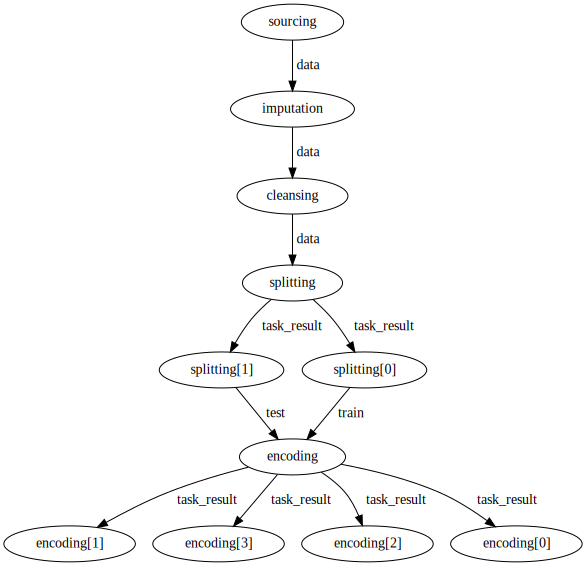

In [4]:
# Run prefect flow
flow.run()

# Export flow as a PDF
flow.visualize(filename="../src/data_pipeline/flow_diagrams/train_dataflow")